# Stats analysis of chapter 2

Looking at Ptilochronology/Feather Growth Bars (FGB) as a function of distance to range edge and forest cover

### Load packages

In [1]:
library(brms) # for Bayesian analysis
library(tidyverse) # for tidy code
library(egg) # for nice professional figures
library(lme4) # for frequentist analysis
library(lmerTest) # for p-values
library(GGally) # for ggpairs


Loading required package: Rcpp

Loading 'brms' package (version 2.16.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: Matr

In [2]:
getwd()

[1] "/Users/tom/OneDrive - Imperial College London/1.PHD/2.R-dir/2.chapter/2.notebook"

### Load forest cover data

In [3]:
FC <- read_csv("../2.data_cleaned/FC_calculated.csv", 
               col_types = cols(
                  species = col_character(),  # load column as character
                  bird_id = col_character()
                    )) %>% dplyr::select(-"X0")

### Load distance to range edge data

In [4]:
dist <- read_csv("../2.data_cleaned/NHM-MZUSP_dist2edge_data.csv")%>%
  dplyr::select(-c(11:14)) %>%  # remove unnecessary columns
  dplyr::select(-"feather_tail") # remove feather_tail column


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  species = col_character(),
  subspecies = col_character(),
  date_collected = col_double(),
  bird_id = col_character(),
  lon_dd = col_double(),
  lat_dd = col_double(),
  location = col_character(),
  sex = col_character(),
  feather_tail = col_character(),
  source = col_character(),
  distance = col_double(),
  inrange = col_logical(),
  in_costal_margin = col_logical(),
  distance_sgn = col_double(),
  dist_km = col_double()
)




### Load FGB data

In [5]:
# load feather growth bar data
FGB <-read_csv("../2.data_cleaned/fgb_width/MZUSP_fgb_mean_per_individual.csv", 
               col_types = cols(
                  species = col_character(),
                  bird_id = col_character(),
                  mean_fgb = col_double(),
                  n_bars = col_double()
                ))

### Manipulate distance to range edge data
Create function to mantain the sign (negative or positive) of the distances to the range edge when calculating the square root. A negative distance distance represents incidence outside the species range, a positive number represents the distance to the range edge from inside the range. 
 

In [6]:
# function to mantain the sign of distance (negative or positive) while calculating sqrt
sqrt_sign <- function(x){sign(x) * sqrt(abs(x))}

# calculate sqrt dist in km
dist <- dist %>%
  mutate(sqrt_dist = sqrt_sign(dist_km)) %>%
  relocate(sqrt_dist, .after = dist_km)

### Make sure that all NAs in column percentage of FC are zeros
The function used to calculate FC in the previous script would give NAs if the landscape metric 'proportion of class' (3 for FC in MAPBIOMAS) was innexistent. That happened mainly for smaller radius like 100 m.  

In [7]:
FC$FC_percentage.value[is.na(FC$FC_percentage.value)] <- 0

### Manipulate FGB data for analysis

In [8]:
FGB_data <- dist %>%
  dplyr::left_join(FGB, by = "bird_id") %>%
  select(-species.y)%>%
  rename(species = species.x) %>%
  filter(!is.na(mean_fgb))

In [9]:
table(is.na(FGB_data$mean_fgb))


FALSE 
  339 

In [10]:
FGB_FC_data <- FGB_data %>%
  dplyr::left_join(FC)

Joining, by = c("species", "bird_id", "lon_dd", "lat_dd", "dist_km")



In [11]:
colnames(FGB_FC_data)

[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "sex"                 "source"             
[10] "dist_km"             "sqrt_dist"           "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value"

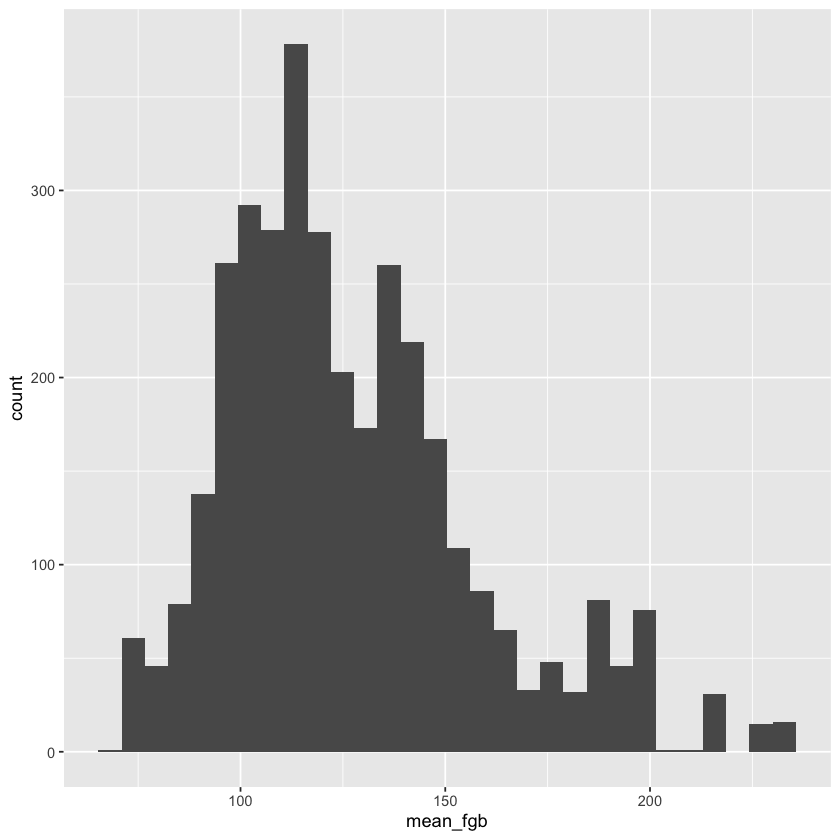

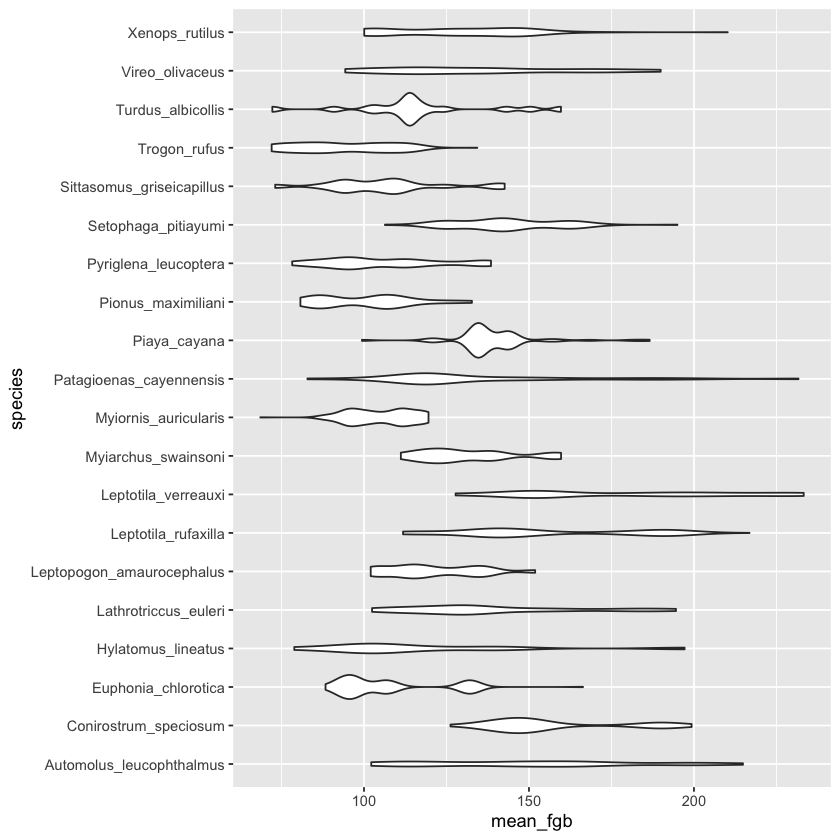

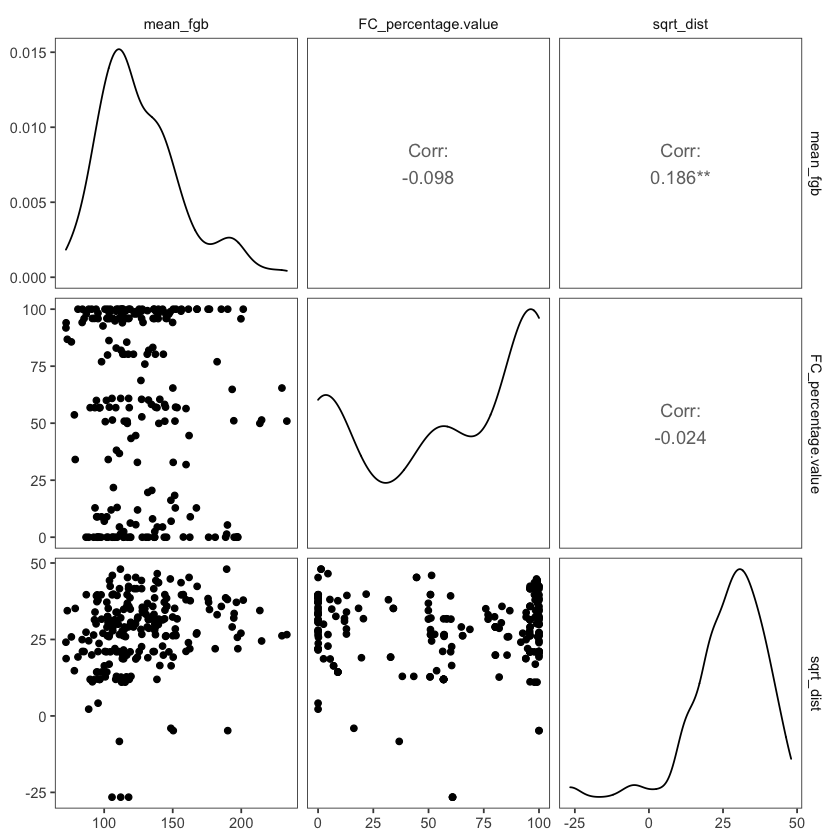

In [12]:
ggplot(FGB_FC_data, aes(x=mean_fgb)) + 
  geom_histogram(bins = 30)

ggplot(FGB_FC_data, aes(x=mean_fgb, y=species)) + 
  geom_violin()
    
FGB_FC_data %>%
filter(FC_buffer == 600) %>%
ggpairs(columns = c('mean_fgb', 'FC_percentage.value', 'sqrt_dist'))+
theme_article()

In [13]:
colnames(FGB_FC_data)

[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "sex"                 "source"             
[10] "dist_km"             "sqrt_dist"           "mean_fgb"           
[13] "n_bars"              "decade"              "biome"              
[16] "geometry"            "file_name"           "FC_buffer"          
[19] "FC_percentage.value"

### Bayesian models for FGB

First look at FGB ~ dist to edge + random effects only.

In [14]:
FGB_fit <- FGB_FC_data %>%
            filter(dist_km >=0, FC_buffer == 600)%>%
               brms::brm(formula = mean_fgb ~ sqrt_dist + (sqrt_dist|species), 
                   data = ., 
                   family = gaussian(link = "identity"),
                   prior = set_prior("normal(0,5)", class = "b"),
                   cores = 4, chains = 4,iter = 5000,
                        control= list(adapt_delta = 0.99))

Compiling Stan program...

Start sampling



In [15]:
summary(FGB_fit)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: mean_fgb ~ sqrt_dist + (sqrt_dist | species) 
   Data: . (Number of observations: 217) 
  Draws: 4 chains, each with iter = 5000; warmup = 2500; thin = 1;
         total post-warmup draws = 10000

Group-Level Effects: 
~species (Number of levels: 20) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)               23.39      7.48     9.47    39.56 1.00     3644
sd(sqrt_dist)                0.32      0.25     0.01     0.92 1.00     1406
cor(Intercept,sqrt_dist)    -0.16      0.55    -0.95     0.92 1.00     5708
                         Tail_ESS
sd(Intercept)                2613
sd(sqrt_dist)                3019
cor(Intercept,sqrt_dist)     4949

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   132.25     11.84   109.66   156.23 1.00     4929     6461
sqrt_dist    -0.23      0.37    -0.96     0.49 1.00     6106     6673


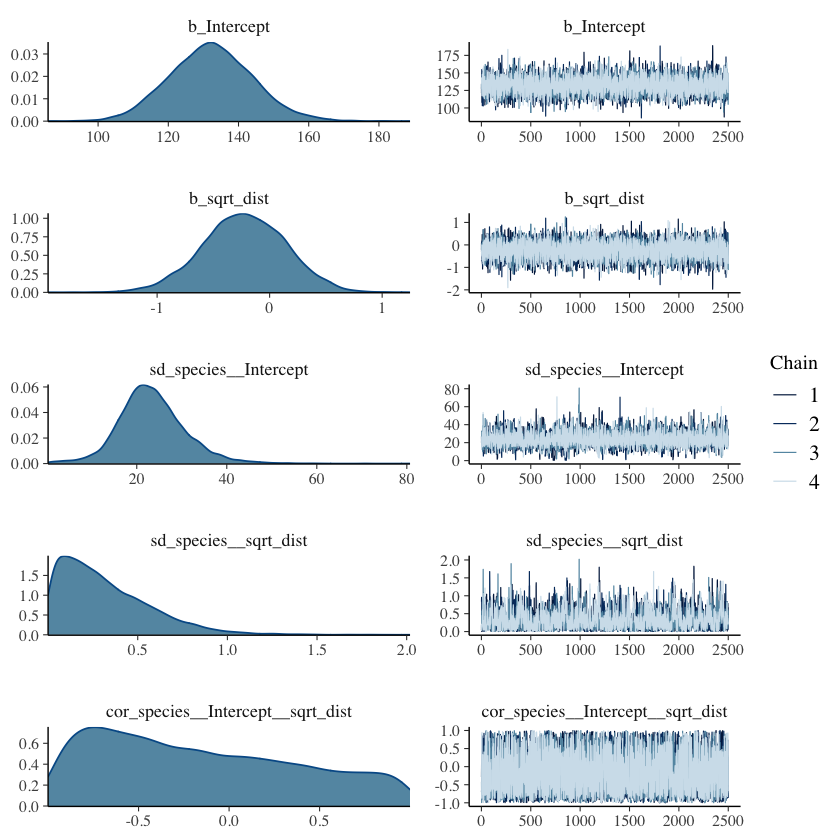

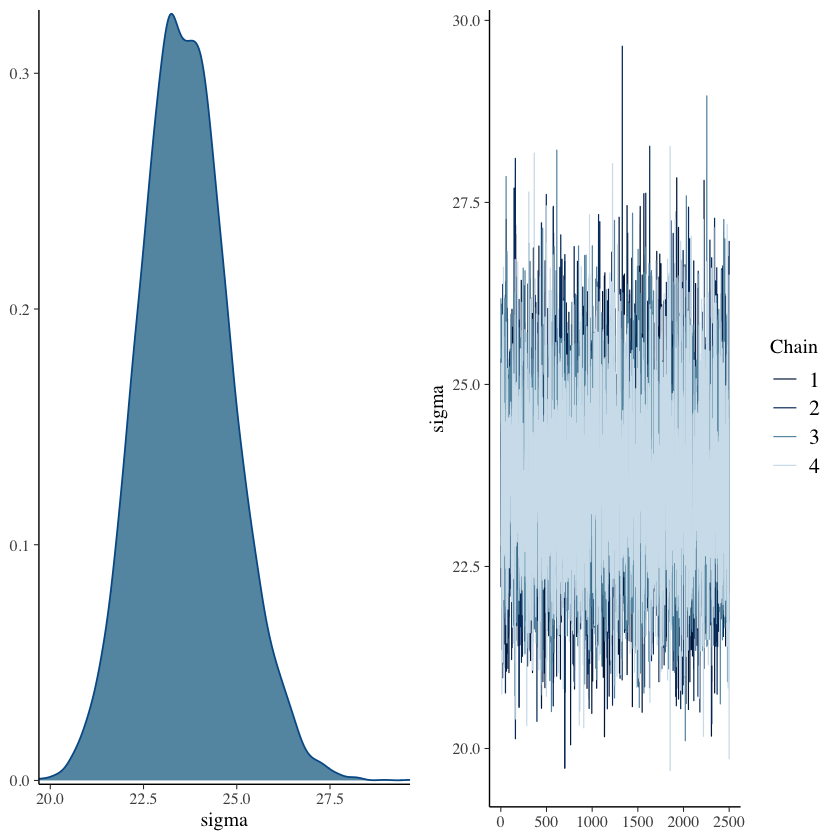

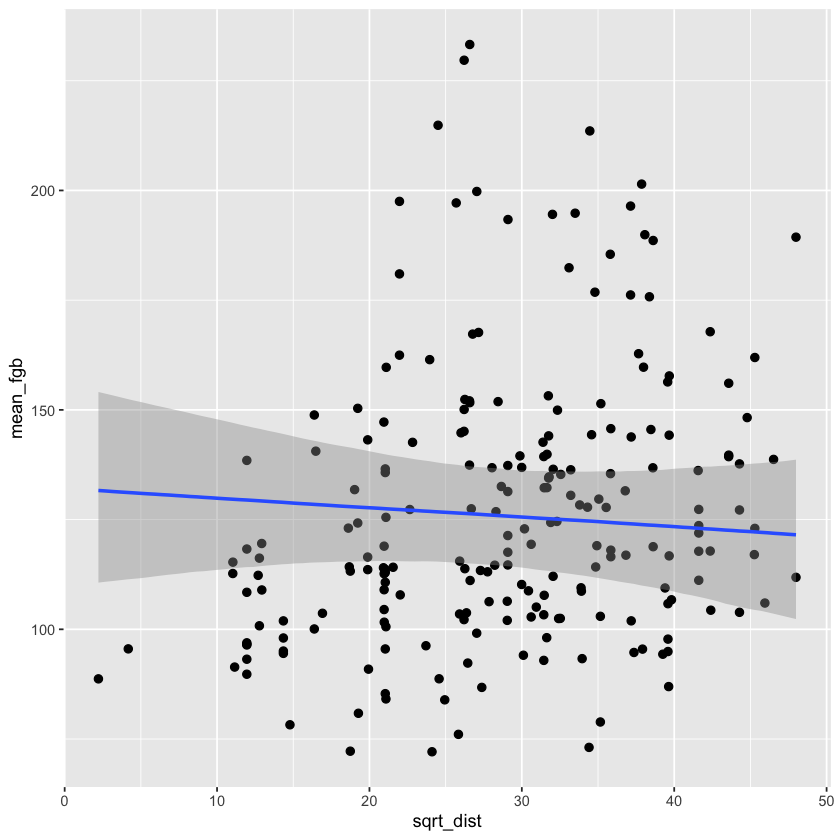

In [16]:
plot(FGB_fit)

plot(conditional_effects(FGB_fit), points = TRUE)

In [17]:
hypothesis(FGB_fit, "sqrt_dist > 0")

Hypothesis Tests for class b:
       Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio Post.Prob
1 (sqrt_dist) > 0    -0.23      0.37    -0.85     0.38       0.38      0.27
  Star
1     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

The hypothesis function shows that is is unlikely that FGB will grow with distance to range edge.

In [18]:
1 / 0.39

[1] 2.564103

In [19]:
FGB_FC_fit <- FGB_FC_data %>%
            filter(FC_buffer == 600) %>%
                brms::brm(formula = mean_fgb ~ sqrt_dist * FC_percentage.value +(sqrt_dist|species), 
                    data = ., 
                    family = gaussian(link = "identity"),
                    prior = set_prior("normal(0,5)", class = "b"),
                    cores = 4, chains = 4, iter = 5000,
                         control= list(adapt_delta=0.99))

Compiling Stan program...

Start sampling



In [20]:
summary(FGB_FC_fit)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: mean_fgb ~ sqrt_dist * FC_percentage.value + (sqrt_dist | species) 
   Data: . (Number of observations: 224) 
  Draws: 4 chains, each with iter = 5000; warmup = 2500; thin = 1;
         total post-warmup draws = 10000

Group-Level Effects: 
~species (Number of levels: 20) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)               25.59      6.85    14.84    41.70 1.00     4942
sd(sqrt_dist)                0.28      0.23     0.01     0.86 1.00     2130
cor(Intercept,sqrt_dist)    -0.26      0.53    -0.97     0.86 1.00     7209
                         Tail_ESS
sd(Intercept)                6421
sd(sqrt_dist)                3851
cor(Intercept,sqrt_dist)     6004

Population-Level Effects: 
                              Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                       138.11     12.44   113.78   163.21 1.00
sqrt_dist                        -0.27      

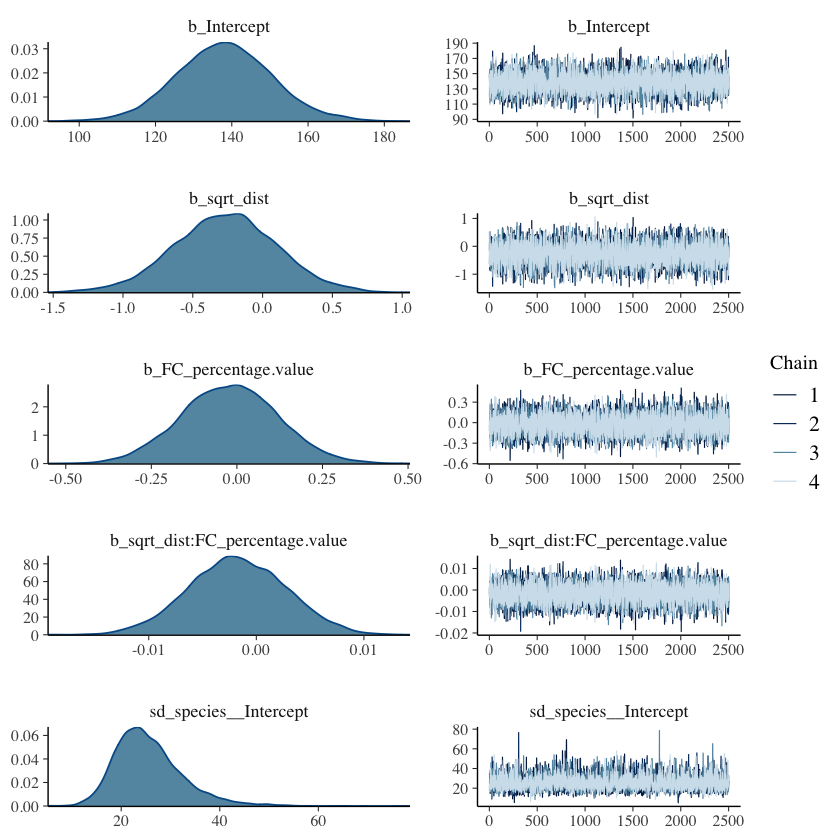

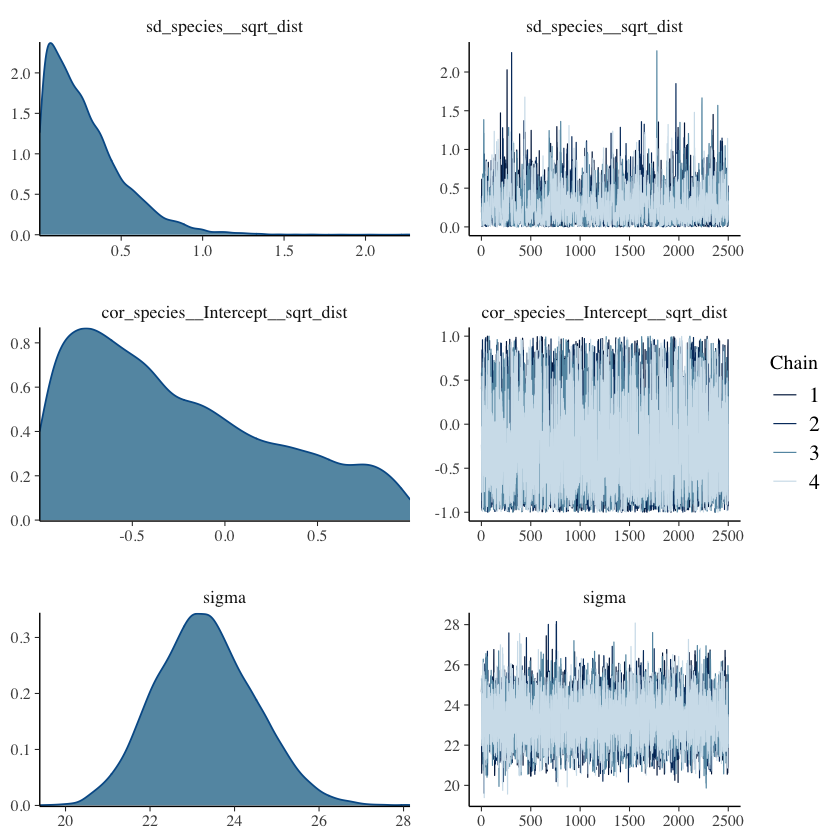

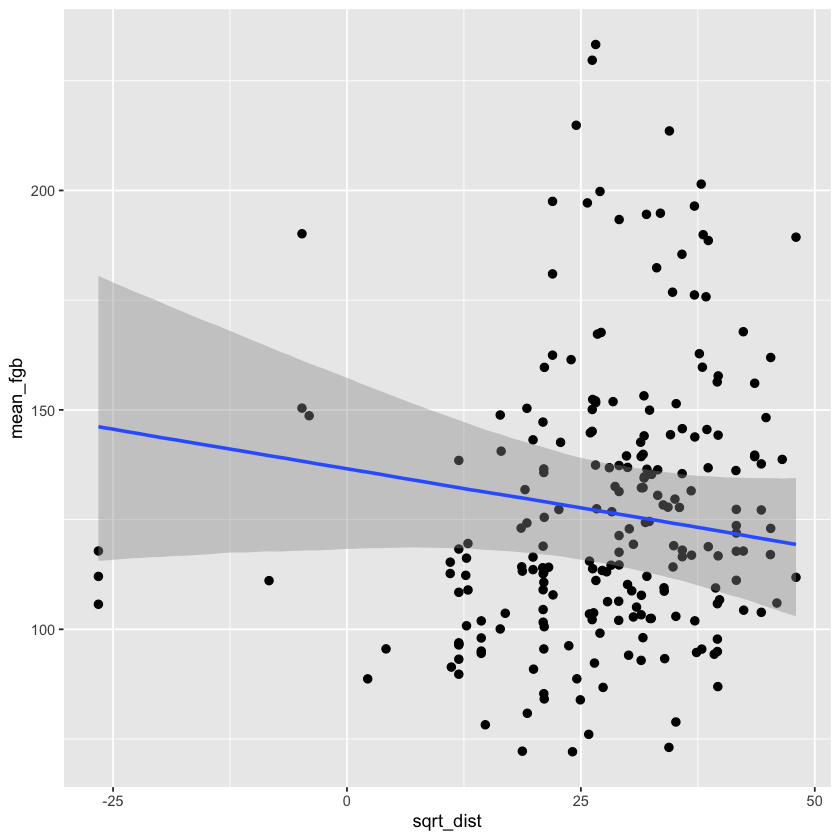

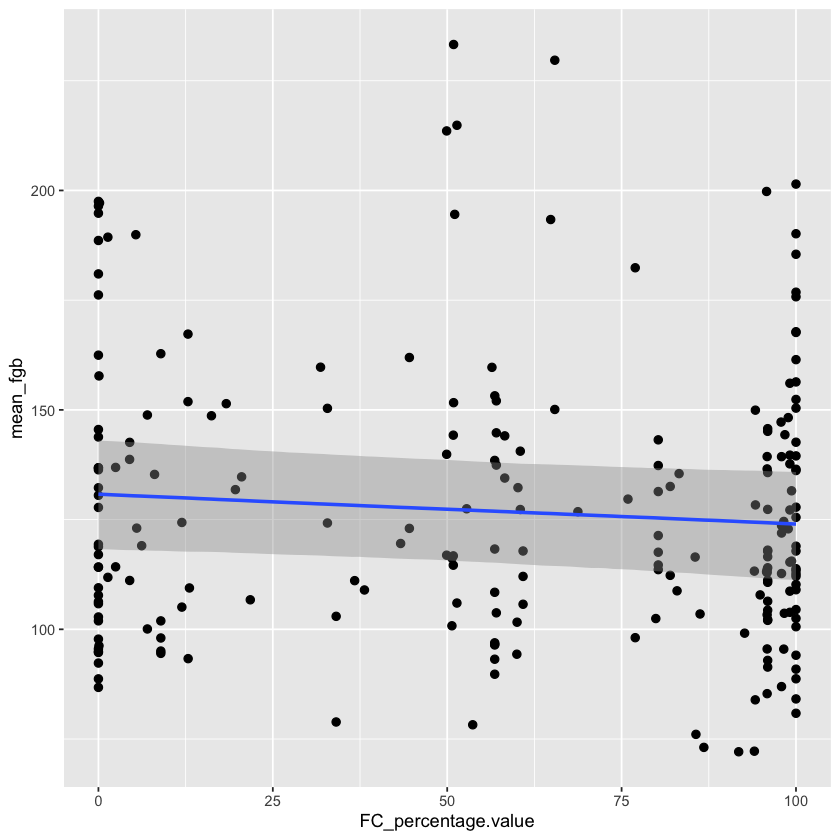

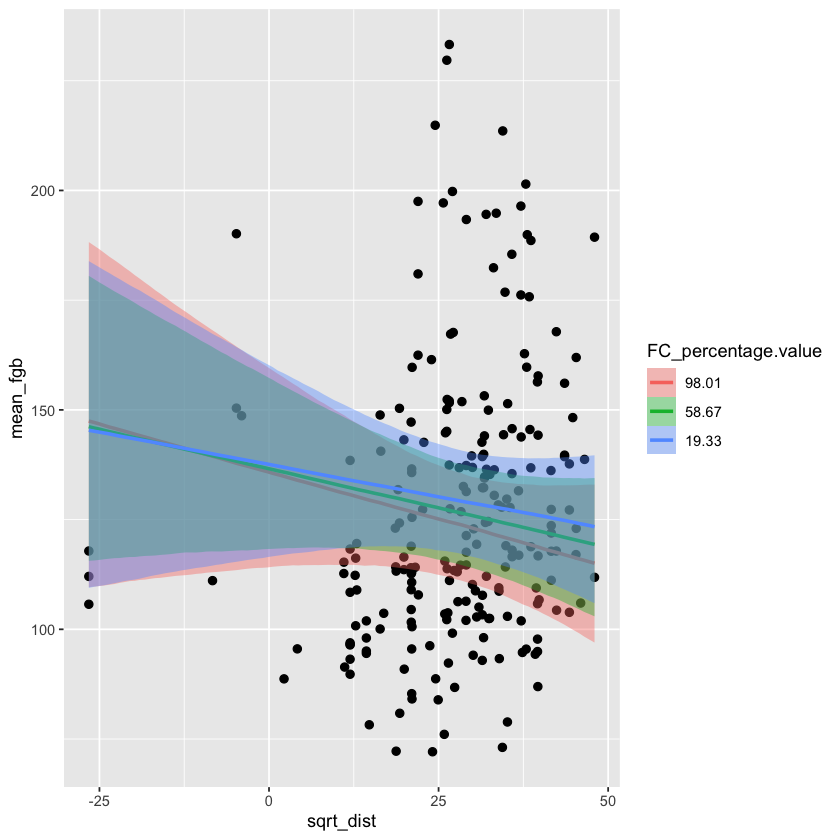

In [21]:
plot(FGB_FC_fit)

plot(conditional_effects(FGB_FC_fit), points = TRUE)

In [22]:
FGB_FC_fit <- FGB_FC_data %>%
            filter(dist_km >= 0, FC_buffer == 600) %>%
                brms::brm(formula = mean_fgb ~ sqrt_dist * FC_percentage.value +(sqrt_dist|species), 
                    data = ., 
                    family = gaussian(link = "identity"),
                    prior = set_prior("normal(0,5)", class = "b"),
                    cores = 4, chains = 4, iter = 5000,
                         control= list(adapt_delta=0.99))

Compiling Stan program...

Start sampling



In [23]:
summary(FGB_FC_fit)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: mean_fgb ~ sqrt_dist * FC_percentage.value + (sqrt_dist | species) 
   Data: . (Number of observations: 217) 
  Draws: 4 chains, each with iter = 5000; warmup = 2500; thin = 1;
         total post-warmup draws = 10000

Group-Level Effects: 
~species (Number of levels: 20) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)               24.28      7.69    10.73    41.58 1.00     4867
sd(sqrt_dist)                0.32      0.26     0.01     0.96 1.00     1685
cor(Intercept,sqrt_dist)    -0.21      0.55    -0.96     0.91 1.00     6944
                         Tail_ESS
sd(Intercept)                4514
sd(sqrt_dist)                3509
cor(Intercept,sqrt_dist)     6138

Population-Level Effects: 
                              Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                       138.53     13.74   112.11   165.73 1.00
sqrt_dist                        -0.29      

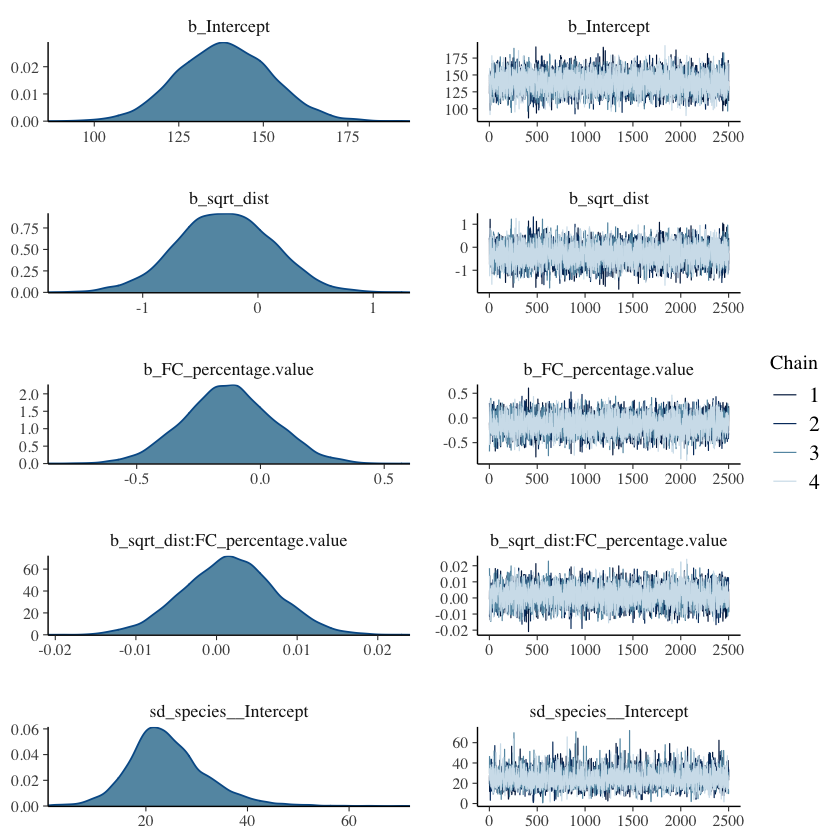

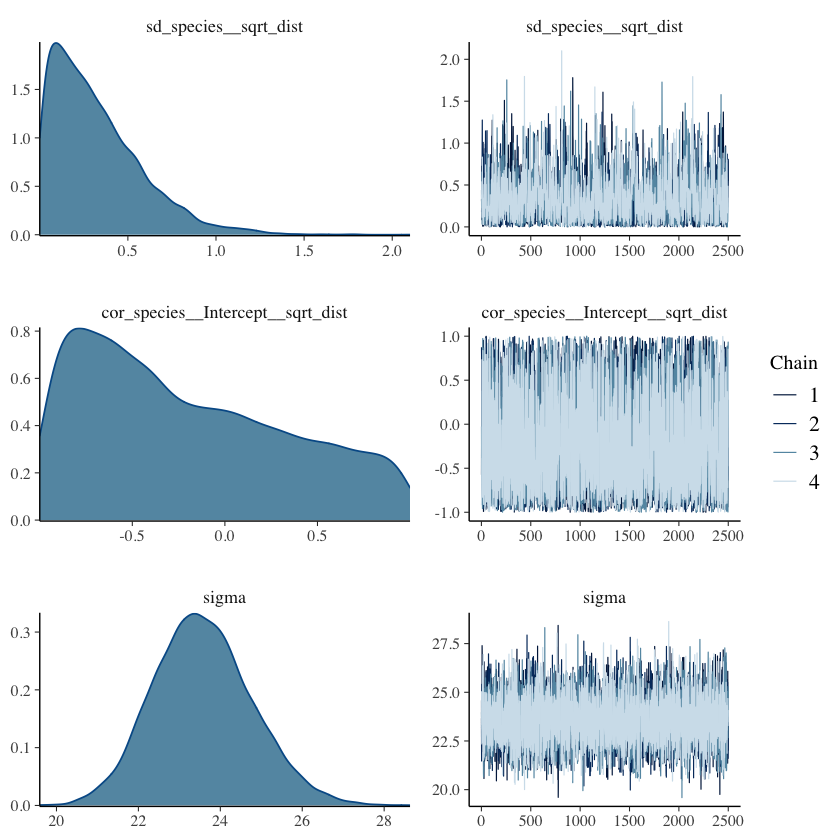

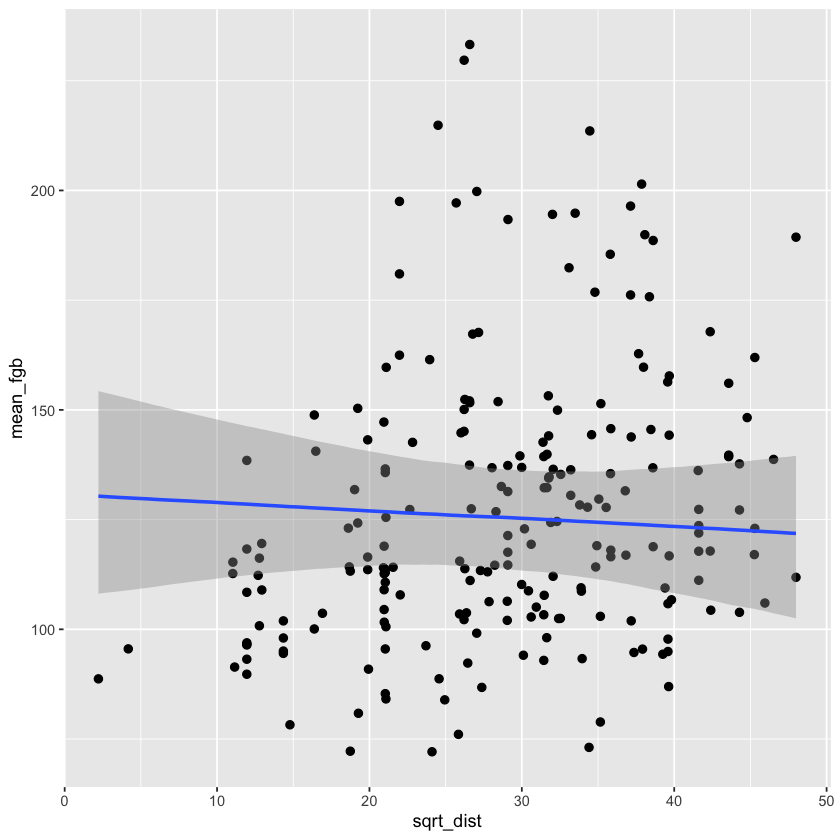

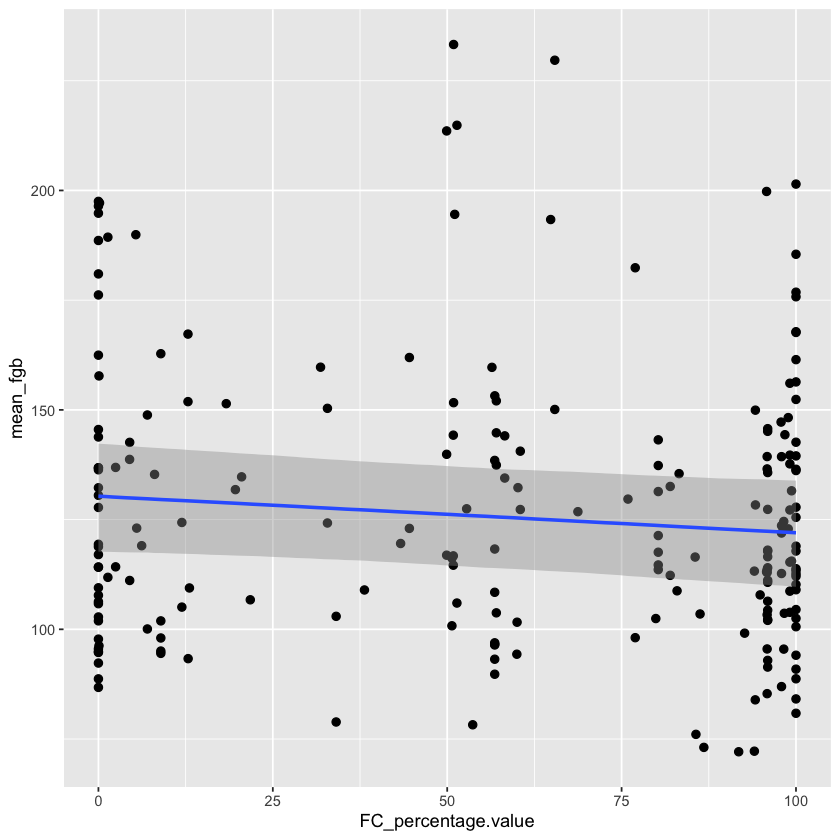

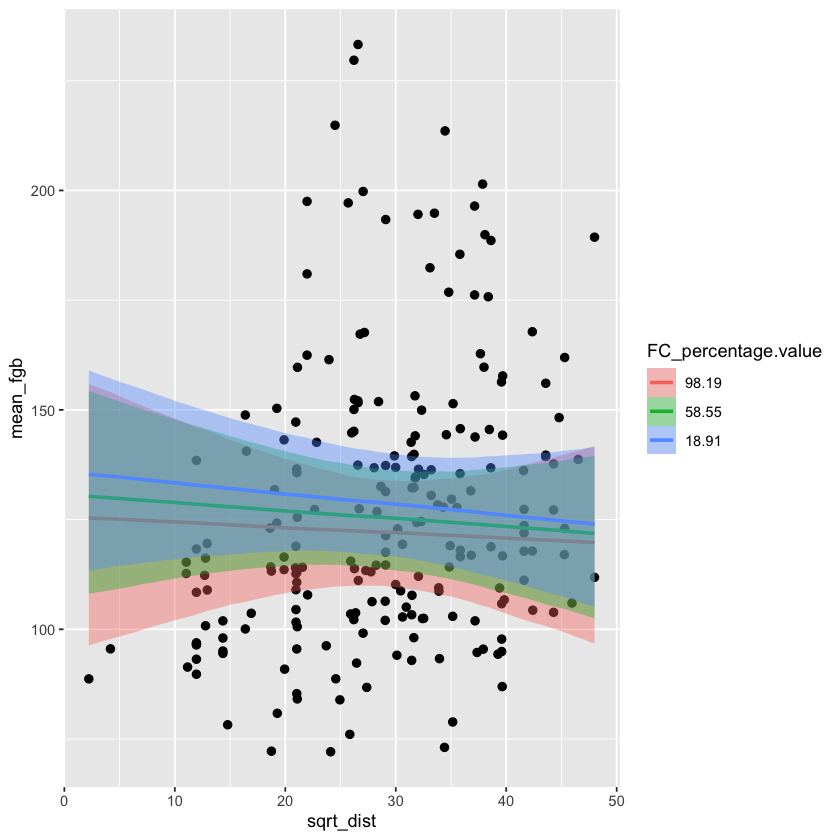

In [24]:
plot(FGB_FC_fit)

plot(conditional_effects(FGB_FC_fit), points = TRUE)

In [25]:
save.image("../2.notebook/FGB_analysis.RData")